# Demo Workflow - Postprocessing & Evaluation of a Trained Model

This notebook contains the postprocessing workflow - how we evaluate the performance of a trained model by analyzing its predictions, RMSE performance, and residuals.

[Source Code: `/src/Postprocessing/utils.py`](../src/Postprocessing/utils.py)

[Documentation: `/docs/guides/Postprocessing/utils.md`](../docs/guides/Postprocessing/utils.md)

## **Introduction**

<div class="alert alert-block alert-info">
      
#### **Notebook Overview:** 

This notebook loads one pre-trained neural network model and shows how we comprehensively evaluate its performance on test data (which the model has never seen). It first introduces each evaluation measurement or visualization and explains how to read and interpret each result. Then, we analyze the real results from our best trained Neural Network model as an example.
    
*Sections:*
    
1. Load trained model
2. Generate predictions
3. Calculate RMSE
4. Plot residuals
5. Plot time series


#### **Purpose:** 
    
The purpose of this notebook is to show the process of evaluating the final models and communicating their effectiveness. We explain which measures we are looking at and why, using the real example of our best NN model. Here, we get predictions from pre-trained models using only test set (generated during preprocessing, see [preprocessing_demo.ipynb](preprocess_demo.ipynb)).
    
This workflow is part of the conclusion or results phase of the project, and should be run only after many different models are experimented with, trained, and optimized using the training and validation data sets. These exploratory-style workflows can be seen in notebooks [baselines_demo.ipynb](baselines_demo.ipynb), [nn_workflow_demo.ipynb](nn_workflow_demo.ipynb), and [gp_demo.ipynb](gp_demo.ipynb)

</div>

In [1]:
import os
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../') ## Move to top level directory

from src.NeuralNetwork.nn import NeuralNetworkModel
from src.Postprocessing.utils import calculate_model_RMSE, calculate_residuals, generate_residual_plots, generate_time_series_plots

import xarray as xr
import pandas as pd

from torch import load

In [2]:
os.getcwd() # Verify this is pointed at the MDS_Antarctica top level folder from the repo

'/media/dan/data/School/MDS_Capstone/MDS_Antarctica'

## 1. Load Trained Model

Load a pre-trained model to be evaluated against the test set. 

We've coded the specific process for **NN models** because there is an extra step involved. The `NeuralNetworkModel` class must be initialized correctly for the pre-trained model file to be loaded. This step will look a little different if the model being loaded is a GP or baseline, but since the focus of this notebook is on evaluating results we've opted not to include those details here.

Trained Neural Network models are saved as `model.pt` files following PyTorch standards. Specifically, this file is a saved `state_dict`, which a newly initialized `NeuralNetworkModel` can import using the `load_state_dict()` method to set the weights to what was learned during training. See [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for more details.

In [3]:
# Initialize model class with same parameters as the trained model
x_vars = ['scaled_deseas_d18O_pr', 'scaled_E', 'scaled_N', 'scaled_dist_to_coast', 'scaled_oro', 'landsfc']
y_vars = ['scaled_deseas_tmp2m', 'scaled_deseas_hgtprs', 'scaled_deseas_pratesfc']
model_architecture = 'CNN-deep2' 
model = NeuralNetworkModel(model_architecture, x_vars, y_vars)

In [4]:
# Load previously trained model from .pt file
trained_model_path = 'results/models/NN-model.pt'
model.load_state_dict(load(trained_model_path))

<All keys matched successfully>

If the NN model loaded successfully, you should get the message:

> \<All keys matched successfully\>

If you get

> `RuntimeError: Error(s) in loading state_dict for NeuralNetworkModel`

This means you initialized the model with different x_vars, y_vars, and/or architecture than the trained model file. 

## 2. Generate Model Predictions on Test Set

Load the test set, and generate predictions. The preprocessed_test_ds.nc file is generated during the preprocessing workflow. See [preprocessing_demo.ipynb](preprocessing_demo.ipynb)

The `predict_inplace()` method generates predictions on a xarray dataset and adds them into the dataset as new variables. See [nn_workflow_demo.ipynb](nn_workflow_demo.ipynb) for more details.

In [5]:
# Load test dataset
test_path = 'data/preprocessed/preprocessed_test_ds.nc'
ds_test = xr.open_dataset(test_path)

# Add predictions to test dataset
ds_eval = model.predict_inplace(ds_test)

## 3. Evaluate RMSE on Test Set

The overall measure of a model's performance is it's root mean squared error (RMSE) score. This is the big picture, overall measure of how well the model's predicted values matched the actual values.

$$
\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{n}(y_i - 
\hat{y}_i)^2}{n}}
$$

For each target, there will be 4 RMSEs output. Using temperature as an example, these are:
1. `tmp2m`: Test RMSE on original temperature inputs (in degrees K)
2. `scaled_tmp2m`: Test RMSE on scaled original temperature (ie. temperature standardized to mean 0 and variance 1)
3. `deseas_tmp2m`: Test RMSE on deseasonalized temperature (original temperatures minus monthly mean temperatures) AKA **temperature anomalies** in degrees K (these are unscaled so variance != 1)
4. `scaled_deseas_tmp2m`: Test RMSE on **scaled temperature anomalies** which have mean 0 and variance 1

When communicating with our partner, we have been using the scaled_deseas (#4) RMSE scores, since they are comparable against one another across variables and because they focus specifically on how well the model does at explaining the harder to explain anomalies, which is the real opportunity for skill or insight with this project. 

In [6]:
# Calculate model RMSEs
rmse_dict = calculate_model_RMSE(ds_eval, scale='original') 
# The scale parameter here defines which RMSE scores you want to see. Use 'original' to see all
pd.DataFrame(rmse_dict, index = ['result']).T

,result
tmp2m,2.069346
scaled_tmp2m,0.129545
deseas_tmp2m,2.069346
scaled_deseas_tmp2m,0.961993
hgtprs,54.602327
scaled_hgtprs,0.501937
deseas_hgtprs,54.602327
scaled_deseas_hgtprs,0.962250
pratesfc,0.000006
scaled_pratesfc,0.406583


On the test set, this model had scaled anomaly RMSE scores of 0.96 for both temperature and geopotential height and 1.07 for precipitation rate. We should expect these three values to be fairly close to one another, since the scaling ensures the model prioritizes performance on all 3 targets equally and the RMSE is a measure sensitive to outliers. 

## 4. Plot Residuals

Visualize the residual plots of the 3 target variables. Any patterns (especially across space or time) indicate that the model is biased in some way and failed to generalize appropriately across the entire dataset. These residual plots help us see whether, and then specifically where and when, these models are good predictors.

The residual plots we designed are a combination of 4 subplots:
1. **Average Residuals** - A map with a colorscale representing the value of the average residuals across all months for each specific lat, lon point. A visualization of regional (spatial) accuracy, where strong colors will be present in areas where the model is strongly biased towards over (red) or under (blue) prediction. 
2. **Std. Dev. of Residuals** - A map with a colorscale representing the standard deviation of the residuals across all moths for each specific lat, lon point. A visualization of regional (spatial) precision. The lower the standard deviation (yellower) a region, the more consistent the model's predictions are in that area *regardless of the model's accuracy*.
3. **Average Residuals by Month** - A cyclical plot depicting the seasonal monthly cycle with a colorscale representing the value of the average residuals over all spatial points in each specific month. This is the same accuracy measure as in subplot 1, but grouping the data differently. Again, strong colors show months where the model is strongly biased towards over (red) or under (blue) prediction. The plot is designed to reveal at a glance how well the model handles the seasonal nature of climate data.
4. **Binned Residuals** - A histogram of all the residuals of this model. This plot shows the shape and spread of all the residuals, and is especially helpful for comparing between different models. An ideal model should look balanced (ie. have no skewness), be centered on zero, and have small tails.

### 4.1 Temperature

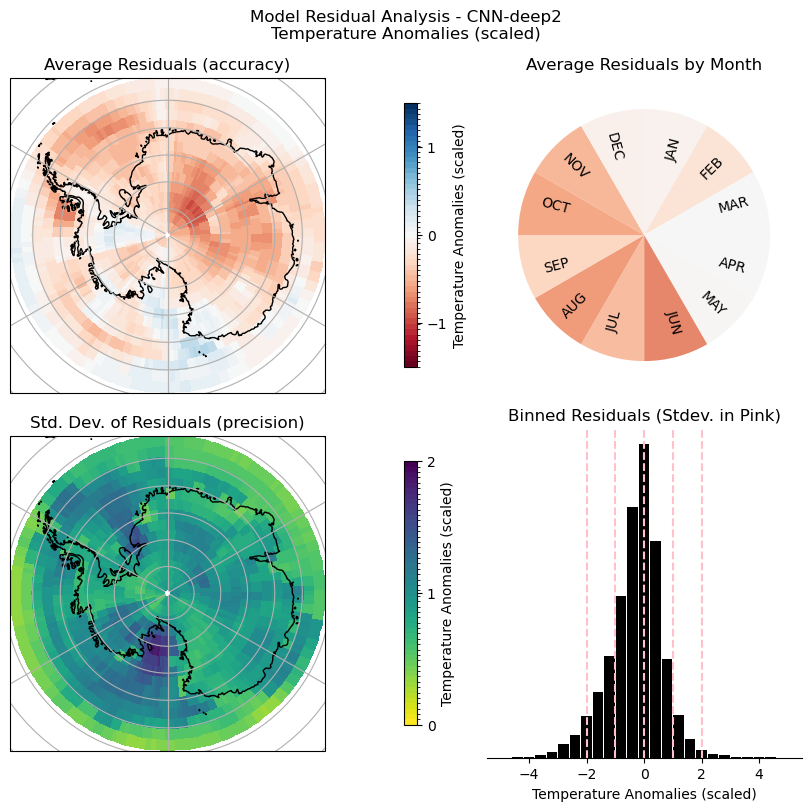

In [7]:
# Temperature Anomalies
generate_residual_plots(ds_eval, 
                        variable = 'resid_scaled_deseas_tmp2m', 
                        label = 'Temperature Anomalies (scaled)', 
                        model_name = model_architecture,
                        out_file = None,
                        show_plot = True)

*Analysis*: The presence of majority red hues in the average residual plots and left-skew of the binned residuals reveal that the model tends to overpredict temperature, especially during the Antarctic spring period between June and November, and to a lesser extent in the north and west areas of the map. The standard deviation of residuals show more precision over land than over the ocean. Some sub-regions, such as the western peninsula, have average residuals close to zero (white) and low standard deviations (yellow-green), suggesting that the model has higher skill predicting temperature there.

### 4.2 Geopotential Height

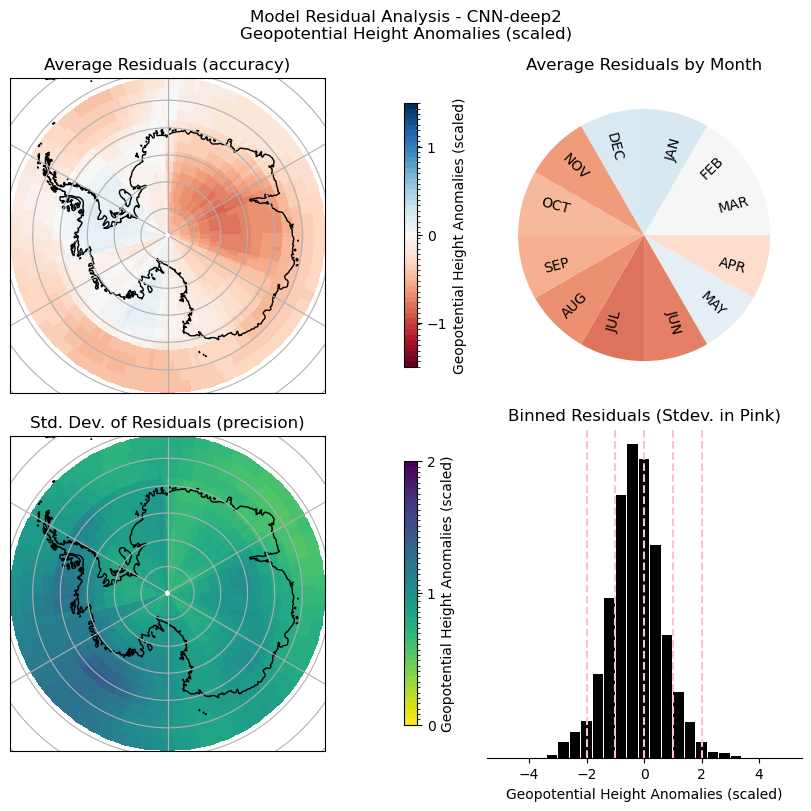

In [8]:
# Geopotential Height Anomalies
generate_residual_plots(ds_eval, 
                        variable = 'resid_scaled_deseas_hgtprs', 
                        label = 'Geopotential Height Anomalies (scaled)', 
                        model_name = model_architecture,
                        out_file = None,
                        show_plot = True)

*Analysis*: Like with temperature, the red hues in the average residual plots and left-skew of the binned residuals reveal that the model tends to overpredict geopotential height. There are spatial and temporal patterns to this bias, both in the north-east areas of the continent on the map and in the distinct Antarcitc spring period between June and November. The standard deviation of residuals appears fairly uniform across the map, but there are some darker blues in the south west quadrant, suggesting the model is less consistent there.

### 4.3 Precipitation

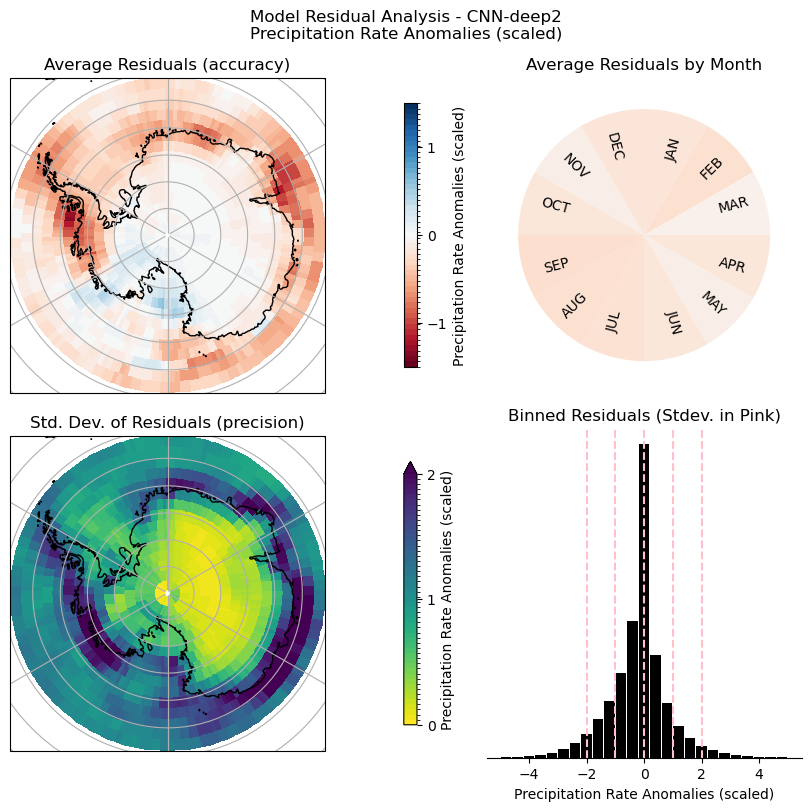

In [9]:
# Precipitation Rate Anomalies
generate_residual_plots(ds_eval, 
                        variable = 'resid_scaled_deseas_pratesfc', 
                        label = 'Precipitation Rate Anomalies (scaled)', 
                        model_name = model_architecture,
                        out_file = None,
                        show_plot = True)

*Analysis*: The top two plots show an unbiased model whose average residuals are near zero almost everywhere. There is also no seasonal pattern to the residuals, and the binned residuals confirm strong central tendency with a very large spike at 0. The standard deviation of residuals map shows the model's weakness: the predictions are erratic and very extreme in all coastal regions of Antarctica. This is where most Antarctic precipitation occurs , so a lack of precision here is problematic.

## 5. Time Series Plots

We developed a final set of plots to look specifically at the seasonal time series nature of the data. In these plots, we pull out 4 specific coordinates in Antarctica and compare the ground truth versus the model predictions over time. These present more granluar view compared to the bigger picture patterns we can observe from the residual plots.

The plots are flexible, and we can specify the following parameters to look for different things:
- *output_var*: one of `'tmp2m'`, `'hgtprs'`, or `'pratesfc'` (The target climate variable to plot)
- *output_scale*: `'scaled_deseas'` (shows scaled anomalies) or `''` (shows original units)
- *num_years*: 'all' or an integer between 1 and 8
- *out_file*: str (file location to save the output image)

We're choosing to show the data in original scale (`output_scale=''`) so the cyclical nature is more apparent. In practice, especially for models trained on anomalies, it's more appropriate to show the data as scaled anomalies (`output_scale='scaled_deseas'`). The challenge of our project is to understand the pattern of the anomalies - we already know the pattern of the seasonal means (it's colder in winter - duh!). *Note this distinction is why we also can't compare RMSE scores between models trained on deseasonalized vs. un-deseasonalized inputs*

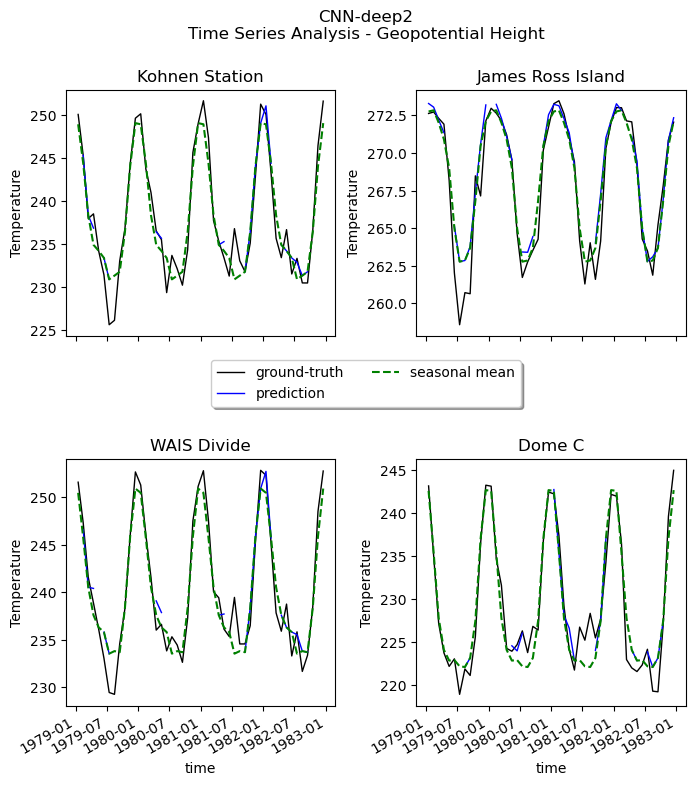

In [10]:
generate_time_series_plots(ds_eval, 
                           output_var="tmp2m", 
                           output_scale='', 
                           num_years=4,
                           label="Time Series Analysis - Geopotential Height", 
                           model_name=model_architecture, 
                           out_file=None, 
                           show_plot=True)

*Analysis*: 

The first thing that sticks out is that the prediction lines are not continuous. We're missing some time slices of data in the test set at all four of these points. We could interpolate to complete these predictions, but this is important to recognize and not something we can easily tell from any of our other plots. 

Where we have made predictions, we seem to be close to the ground truth most of the time (remember our RMSE is about 2 degrees). We can compare whether the blue prediction line follows the dashed season mean line or the black ground-truth line to infer how well the model is understanding the anomalies. July 1980 at Dome C and January 1982 at WAIS Divide show examples where the ground-truth deviated from the seasonal mean and the model caught the anomaly correctly. The opposite happens around July 1982 at WAIS Divide, where the model more or less follows the seasonal mean line exactly and misses the anomalies above and below the line. 

As we might expect, the most extreme values are the hardest for the model to predict, and although the model seems to do okay overall here from what we can see, getting the coldest and warmest months appears to be where it struggles the most. 